# Project 2: Intrusion Detection System
##### Satjyot Atwal, Hung Quach
##### CSC 180, Section 1

## Imports and Helper Functions

In [1]:
from collections.abc import Sequence
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import csv
from IPython.display import display

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

save_path = "./Saved_NN/"


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def report_coef(names, coef, intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}),figsize = (20,40) , fontsize = 15)
    return r

def cm_visual(y_true, pred, outcome):
    cm = metrics.confusion_matrix(y_true, pred)
    print(cm)

    plt.figure()
    plot_confusion_matrix(cm, outcome)
    plt.show()

    print(metrics.classification_report(y_true, pred))

## Reading the data

In [73]:
column_names = ['duration','protocol','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
'num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells',
'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
'dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']

data = pd.read_csv('network_intrusion_data.csv', sep = ',', header = None, names = column_names)
data

,duration,protocol,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [74]:
data.dtypes

duration                         int64
protocol                        object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

## Data Preprocessing

### Check if we have any null value in the data

In [75]:
data.isnull().sum()

duration                       0
protocol                       0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

### Check to see if duplicates exist

In [76]:
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 348435


### Remove the duplicated value

In [77]:
data.drop_duplicates(inplace = True)
data.reset_index(inplace= True)
data.drop('index', axis=1, inplace=True)

In [78]:
data

,duration,protocol,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145581,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
145582,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
145583,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
145584,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


### Encoding categorical features

In [79]:
encode_text_dummy(data,'protocol')
encode_text_dummy(data,'service')
encode_text_dummy(data,'flag')
encode_text_dummy(data,'land')
encode_text_dummy(data,'logged_in')
encode_text_dummy(data,'root_shell')
encode_text_dummy(data,'su_attempted')
encode_text_dummy(data,'is_host_login')
encode_text_dummy(data,'is_guest_login')

In [80]:
data.shape

(145586, 125)

### Normalizing numeric features using z-scores

In [81]:
for i in range (len(data.columns)):
    print(data.columns[i])

duration
src_bytes
dst_bytes
wrong_fragment
urgent
hot
num_failed_logins
num_compromised
num_root
num_file_creations
num_shells
num_access_files
num_outbound_cmds
count
srv_count
serror_rate
srv_serror_rate
rerror_rate
srv_rerror_rate
same_srv_rate
diff_srv_rate
srv_diff_host_rate
dst_host_count
dst_host_srv_count
dst_host_same_srv_rate
dst_host_diff_srv_rate
dst_host_same_src_port_rate
dst_host_srv_diff_host_rate
dst_host_serror_rate
dst_host_srv_serror_rate
dst_host_rerror_rate
dst_host_srv_rerror_rate
outcome
protocol-icmp
protocol-tcp
protocol-udp
service-IRC
service-X11
service-Z39_50
service-auth
service-bgp
service-courier
service-csnet_ns
service-ctf
service-daytime
service-discard
service-domain
service-domain_u
service-echo
service-eco_i
service-ecr_i
service-efs
service-exec
service-finger
service-ftp
service-ftp_data
service-gopher
service-hostnames
service-http
service-http_443
service-imap4
service-iso_tsap
service-klogin
service-kshell
service-ldap
service-link
service-l

In [82]:
outcome_index = data.columns.get_loc('outcome')
print('Outcome index is: ', outcome_index)

Outcome index is:  32


In [83]:
for i in range (outcome_index):
    encode_numeric_zscore(data, data.columns[i])

### Check if we have any null value in the data after normalizing

In [84]:
# prints the names of the columns that have NaN values
data.columns[data.isna().any()].tolist()

['num_outbound_cmds']

In [85]:
# prints the number of NaN values in the column
data['num_outbound_cmds'].isnull().sum()

145586

In [86]:
print(data['num_outbound_cmds'])

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
145581   NaN
145582   NaN
145583   NaN
145584   NaN
145585   NaN
Name: num_outbound_cmds, Length: 145586, dtype: float64


### Drop the column with all null values. 
##### These values became null after normalization due to all their values being 0. The equation of z-score is z = x - mean / std. If all values are 0, std = 0. This means the program is trying to divide by 0 which is undefined. 

In [87]:
data.drop('num_outbound_cmds', axis=1, inplace=True)

In [88]:
data.shape

(145586, 124)

#### Make a copy of the dataframe before converting outcome to binary to use for multi-class classification

In [89]:
multi_data = data.copy(deep=True)

### Making outcome column binary

In [19]:
for i in range (data.shape[0]):
    if ('normal' not in data['outcome'][i]):
        data['outcome'][i] = 'attack'

C:\Users\zey13\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Count of each distinct value in outcome feature.

In [20]:
data.groupby('outcome')['outcome'].count()

outcome
attack     57754
normal.    87832
Name: outcome, dtype: int64

In [21]:
outcome = encode_text_index(data, 'outcome')
print(outcome)
data['outcome']

['attack' 'normal.']


0         1
1         1
2         1
3         1
4         1
         ..
145581    1
145582    1
145583    1
145584    1
145585    1
Name: outcome, Length: 145586, dtype: int32

### Check if we have any null value in the data again

In [22]:
# prints how many columns have NaN values
data.isnull().any().sum()

0

### Check the data type off all the features

In [23]:
for i in data.dtypes:
    print(i)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
int32
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


### Saving preprocessed dataframe

In [24]:
data.to_csv('final_data.csv', index=False)
data

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,...,logged_in-0,logged_in-1,root_shell-0,root_shell-1,su_attempted-0,su_attempted-1,su_attempted-2,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.10785,-0.004293,0.042595,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
1,-0.10785,-0.004261,-0.039036,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
2,-0.10785,-0.004263,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
3,-0.10785,-0.004272,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
4,-0.10785,-0.004273,-0.013613,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145581,-0.10785,-0.004222,-0.016096,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
145582,-0.10785,-0.004237,-0.009436,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
145583,-0.10785,-0.004281,-0.027295,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
145584,-0.10785,-0.004232,-0.027295,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0


### Loading preprocessed dataframe from saved file

In [25]:
final_data = pd.read_csv('final_data.csv', delimiter =",")
final_data

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,...,logged_in-0,logged_in-1,root_shell-0,root_shell-1,su_attempted-0,su_attempted-1,su_attempted-2,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.10785,-0.004293,0.042595,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
1,-0.10785,-0.004261,-0.039036,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
2,-0.10785,-0.004263,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
3,-0.10785,-0.004272,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
4,-0.10785,-0.004273,-0.013613,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145581,-0.10785,-0.004222,-0.016096,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
145582,-0.10785,-0.004237,-0.009436,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
145583,-0.10785,-0.004281,-0.027295,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0
145584,-0.10785,-0.004232,-0.027295,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01039,-0.020694,...,0,1,1,0,1,0,0,1,1,0


## Feature Importance Analysis using Logistic Regression

### Training and Test Split for logistic regression

In [26]:
reg_data = final_data.drop('outcome', axis=1)

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(reg_data, final_data['outcome'], test_size=0.2, random_state=45)

# Training Set
print(x_train_reg.shape)
print(y_train_reg.shape)

# Test set
print(x_test_reg.shape)
print(y_test_reg.shape)

(116468, 123)
(116468,)
(29118, 123)
(29118,)


In [27]:
# Create logistic regression model
regressor = LogisticRegression(max_iter=500)

# Fit/train logistic regression
regressor.fit(x_train_reg, y_train_reg)

# Predict
pred = regressor.predict(x_test_reg)

C:\Users\zey13\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [28]:
names = list(final_data.columns.values)
names.remove("outcome")
names = np.array(names)
names

array(['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent',
       'hot', 'num_failed_logins', 'num_compromised', 'num_root',
       'num_file_creations', 'num_shells', 'num_access_files', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
       'protocol-icmp', 'protocol-tcp', 'protocol-udp', 'service-IRC',
       'service-X11', 'service-Z39_50', 'service-auth', 'service-bgp',
       'service-courier', 'service-csnet_ns', 'service-ctf',
       'service-daytime', 'service-discard', 'service-domain',
       'service-domain_u', 'service-echo', 'service-eco_i',
       'service-ecr

,coef,positive
num_compromised,-11.346563,False
service-private,-6.291118,False
is_guest_login-0,-3.633135,False
flag-RSTR,-3.433970,False
flag-S0,-2.895138,False
...,...,...
is_guest_login-1,3.661393,True
service-telnet,3.883232,True
service-IRC,5.440288,True
flag-REJ,5.832736,True


Intercept: [2.6294499]


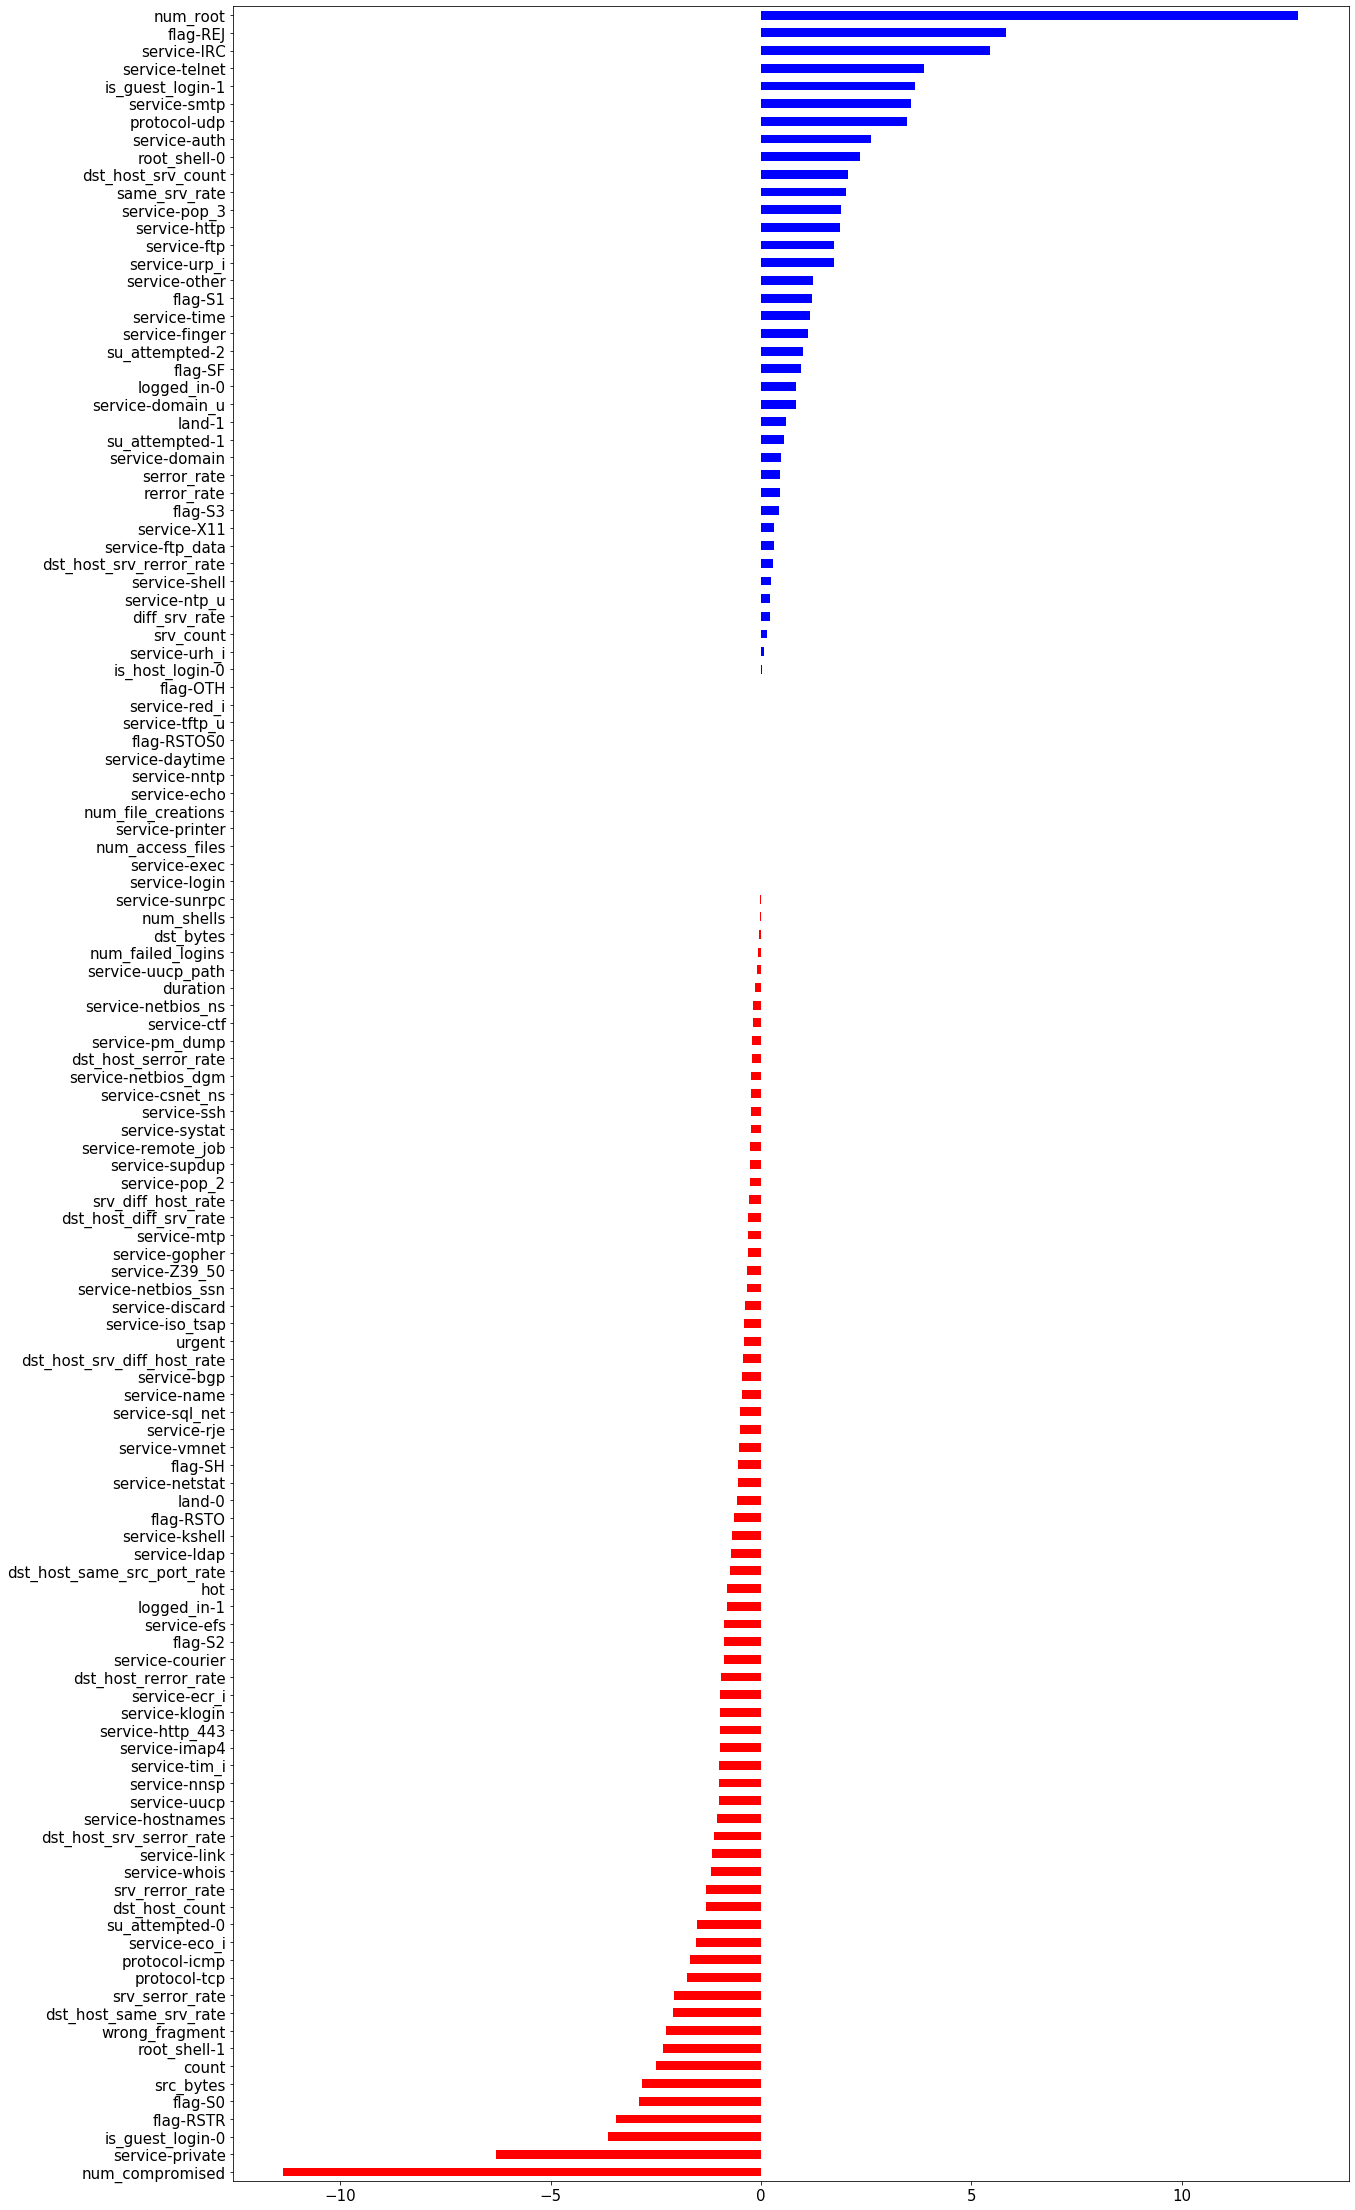

In [29]:
coefs = report_coef(names, regressor.coef_[0], regressor.intercept_)

### Dropping columns that have a coefficient lower than absolute value of .2. 
#### These do not help us much in predicting the target.

In [30]:
index_names = coefs[ (coefs['coef'] < .2) & (coefs['coef'] > -.2) ].index

In [31]:
print(len(index_names))
list(index_names)

23


['service-ctf',
 'service-netbios_ns',
 'duration',
 'service-uucp_path',
 'num_failed_logins',
 'dst_bytes',
 'num_shells',
 'service-sunrpc',
 'service-login',
 'service-exec',
 'num_access_files',
 'service-printer',
 'num_file_creations',
 'service-echo',
 'service-nntp',
 'service-daytime',
 'flag-RSTOS0',
 'service-tftp_u',
 'service-red_i',
 'flag-OTH',
 'is_host_login-0',
 'service-urh_i',
 'srv_count']

In [32]:
reg_final_data = final_data.drop(index_names, axis=1, inplace=False)
reg_final_data

,src_bytes,wrong_fragment,urgent,hot,num_compromised,num_root,count,serror_rate,srv_serror_rate,rerror_rate,...,land-1,logged_in-0,logged_in-1,root_shell-0,root_shell-1,su_attempted-0,su_attempted-1,su_attempted-2,is_guest_login-0,is_guest_login-1
0,-0.004293,-0.084394,-0.004737,-0.070209,-0.007905,-0.01039,-0.661633,-0.643359,-0.642797,-0.350707,...,0,0,1,1,0,1,0,0,1,0
1,-0.004261,-0.084394,-0.004737,-0.070209,-0.007905,-0.01039,-0.661633,-0.643359,-0.642797,-0.350707,...,0,0,1,1,0,1,0,0,1,0
2,-0.004263,-0.084394,-0.004737,-0.070209,-0.007905,-0.01039,-0.661633,-0.643359,-0.642797,-0.350707,...,0,0,1,1,0,1,0,0,1,0
3,-0.004272,-0.084394,-0.004737,-0.070209,-0.007905,-0.01039,-0.681566,-0.643359,-0.642797,-0.350707,...,0,0,1,1,0,1,0,0,1,0
4,-0.004273,-0.084394,-0.004737,-0.070209,-0.007905,-0.01039,-0.681566,-0.643359,-0.642797,-0.350707,...,0,0,1,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145581,-0.004222,-0.084394,-0.004737,-0.070209,-0.007905,-0.01039,-0.701499,-0.643359,-0.642797,-0.350707,...,0,0,1,1,0,1,0,0,1,0
145582,-0.004237,-0.084394,-0.004737,-0.070209,-0.007905,-0.01039,-0.681566,-0.643359,-0.642797,-0.350707,...,0,0,1,1,0,1,0,0,1,0
145583,-0.004281,-0.084394,-0.004737,-0.070209,-0.007905,-0.01039,-0.681566,-0.268002,-0.400274,-0.350707,...,0,0,1,1,0,1,0,0,1,0
145584,-0.004232,-0.084394,-0.004737,-0.070209,-0.007905,-0.01039,-0.681566,-0.643359,-0.642797,-0.350707,...,0,0,1,1,0,1,0,0,1,0


### Making dataframe into a form that tensorflow accepts

In [33]:
x, y = to_xy(reg_final_data, 'outcome')
x.shape

(145586, 100)

In [34]:
y.shape

(145586, 2)

## Training and Test Split
#### Dividing data set into training and test sets. 80% of the records are part of the training set and 20% are for testing. The outcome column is our target (output).

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=45)

# Training Set
print(x_train.shape)
print(y_train.shape)

# Test set
print(x_test.shape)
print(y_test.shape)

(116468, 100)
(116468, 2)
(29118, 100)
(29118, 2)


## Neural Network Models

### Fully-Connected Neural network with 4 total layers. 2 hidden layers that have 50, 25 neurons and use relu activation functions. Adam optimizer.

In [36]:
# Save best model with best weights
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, "relu_adam_model.hdf5"), 
                               verbose=0, save_best_only=True)

# Run model training three times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    relu_adam_model = Sequential()

    relu_adam_model.add(Dense(50, input_dim=x_train.shape[1], activation='relu'))
    relu_adam_model.add(Dense(25, activation='relu'))
    relu_adam_model.add(Dense(y_train.shape[1], activation='softmax'))

    # Use categorical crossentropy loss since it is a classification problem
    relu_adam_model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')

    relu_adam_model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Train on 116468 samples, validate on 29118 samples
Epoch 1/1000
116468/116468 - 14s - loss: 0.0193 - val_loss: 0.0149
Epoch 2/1000
116468/116468 - 13s - loss: 0.0083 - val_loss: 0.0124
Epoch 3/1000
116468/116468 - 13s - loss: 0.0071 - val_loss: 0.0156
Epoch 4/1000
116468/116468 - 13s - loss: 0.0066 - val_loss: 0.0136
Epoch 5/1000
116468/116468 - 13s - loss: 0.0060 - val_loss: 0.0150
Epoch 00005: early stopping

Run:  2
Train on 116468 samples, validate on 29118 samples
Epoch 1/1000
116468/116468 - 13s - loss: 0.0202 - val_loss: 0.0107
Epoch 2/1000
116468/116468 - 13s - loss: 0.0085 - val_loss: 0.0106
Epoch 3/1000
116468/116468 - 13s - loss: 0.0070 - val_loss: 0.0123
Epoch 4/1000
116468/116468 - 13s - loss: 0.0059 - val_loss: 0.0139
Epoch 00004: early stopping

Run:  3
Train on 116468 samples, validate on 29118 samples
Epoch 1/1000
116468/116468 - 13s - loss: 0.0197 - val_loss: 0.0121
Epoch 2/1000
116468/116468 - 13s - loss: 0.0081 - val_loss: 0.0105
Epoch 3/1000
116468/116468 

### Convert input and output to a form that can be used in CNN. View each record as an image.

In [37]:
x_train_cnn = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], 1))
x_test_cnn = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], 1))
input_shape = (1, x_train.shape[1], 1)

print(x_train_cnn.shape)
print(x_test_cnn.shape)
print(input_shape)

(116468, 1, 100, 1)
(29118, 1, 100, 1)
(1, 100, 1)


### Convolutional Neural network with 9 total layers. Two convolutional layers, one with 32 kernels and one with 64. 1 by 5 kernel size. Relu activation function. Adam optimizer. One Dense hidden layer with 1000 neurons. Dropout of 0.1

In [38]:
# Save best model with best weights
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, "relu_adam_cnn.hdf5"), 
                               verbose=0, save_best_only=True)

# Run model training three times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    relu_adam_cnn = Sequential()
    
    relu_adam_cnn.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
    relu_adam_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    relu_adam_cnn.add(Conv2D(64, (1, 5), activation='relu'))
    relu_adam_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    relu_adam_cnn.add(Flatten())
    relu_adam_cnn.add(Dense(1000, activation='relu'))
    relu_adam_cnn.add(Dropout(0.1))
    relu_adam_cnn.add(Dense(y_train.shape[1], activation='softmax'))

    # Use categorical crossentropy loss since it is a classification problem
    relu_adam_cnn.compile(loss='categorical_crossentropy', optimizer='adam')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')

    relu_adam_cnn.fit(x_train_cnn, y_train, validation_data=(x_test_cnn, y_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Train on 116468 samples, validate on 29118 samples
Epoch 1/1000
116468/116468 - 21s - loss: 0.0188 - val_loss: 0.0124
Epoch 2/1000
116468/116468 - 19s - loss: 0.0091 - val_loss: 0.0130
Epoch 3/1000
116468/116468 - 19s - loss: 0.0077 - val_loss: 0.0119
Epoch 4/1000
116468/116468 - 18s - loss: 0.0064 - val_loss: 0.0207
Epoch 00004: early stopping

Run:  2
Train on 116468 samples, validate on 29118 samples
Epoch 1/1000
116468/116468 - 20s - loss: 0.0183 - val_loss: 0.0128
Epoch 2/1000
116468/116468 - 19s - loss: 0.0089 - val_loss: 0.0107
Epoch 3/1000
116468/116468 - 22s - loss: 0.0071 - val_loss: 0.0113
Epoch 4/1000
116468/116468 - 20s - loss: 0.0064 - val_loss: 0.0136
Epoch 5/1000
116468/116468 - 19s - loss: 0.0060 - val_loss: 0.0149
Epoch 00005: early stopping

Run:  3
Train on 116468 samples, validate on 29118 samples
Epoch 1/1000
116468/116468 - 19s - loss: 0.0193 - val_loss: 0.0153
Epoch 2/1000
116468/116468 - 17s - loss: 0.0091 - val_loss: 0.0129
Epoch 3/1000
116468/116468 

### Convolutional Neural network with 7 total layers. One convolutional layer, one with 128 kernels. 1 by 5 kernel size. Sigmoid activation function. SGD optimizer. One Dense hidden layer with 500 neurons. Dropout of 0.2

In [39]:
# Save best model with best weights
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, "sigmoid_sgd_cnn.hdf5"), 
                               verbose=0, save_best_only=True)

# Run model training one time only since sgd optimizer takes longer
for i in range(1):
    print('\nRun: ', i + 1)
    
    sigmoid_sgd_cnn = Sequential()
    
    sigmoid_sgd_cnn.add(Conv2D(128, kernel_size=(1, 5), strides=(1, 1), activation='sigmoid', input_shape=input_shape))
    sigmoid_sgd_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    sigmoid_sgd_cnn.add(Flatten())
    sigmoid_sgd_cnn.add(Dense(500, activation='sigmoid'))
    sigmoid_sgd_cnn.add(Dropout(0.2))
    sigmoid_sgd_cnn.add(Dense(y_train.shape[1], activation='softmax'))

    # Use categorical crossentropy loss since it is a classification problem
    sigmoid_sgd_cnn.compile(loss='categorical_crossentropy', optimizer='sgd')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')

    sigmoid_sgd_cnn.fit(x_train_cnn, y_train, validation_data=(x_test_cnn, y_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Train on 116468 samples, validate on 29118 samples
Epoch 1/1000
116468/116468 - 17s - loss: 0.3077 - val_loss: 0.1176
Epoch 2/1000
116468/116468 - 17s - loss: 0.0986 - val_loss: 0.0784
Epoch 3/1000
116468/116468 - 21s - loss: 0.0837 - val_loss: 0.0746
Epoch 4/1000
116468/116468 - 17s - loss: 0.0765 - val_loss: 0.0732
Epoch 5/1000
116468/116468 - 22s - loss: 0.0723 - val_loss: 0.0676
Epoch 6/1000
116468/116468 - 17s - loss: 0.0691 - val_loss: 0.0648
Epoch 7/1000
116468/116468 - 16s - loss: 0.0657 - val_loss: 0.0604
Epoch 8/1000
116468/116468 - 16s - loss: 0.0624 - val_loss: 0.0585
Epoch 9/1000
116468/116468 - 16s - loss: 0.0603 - val_loss: 0.0557
Epoch 10/1000
116468/116468 - 16s - loss: 0.0578 - val_loss: 0.0535
Epoch 11/1000
116468/116468 - 16s - loss: 0.0555 - val_loss: 0.0516
Epoch 12/1000
116468/116468 - 16s - loss: 0.0528 - val_loss: 0.0506
Epoch 13/1000
116468/116468 - 16s - loss: 0.0507 - val_loss: 0.0472
Epoch 14/1000
116468/116468 - 16s - loss: 0.0488 - val_loss: 0.04

### Convolutional Neural network with 9 total layers. Two convolutional layers, one with 8 kernels and one with 16. 1 by 10 kernel size. Relu activation function. Adam optimizer. One Dense hidden layer with 1000 neurons. Dropout of 0.1

In [40]:
# Save best model with best weights
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, "tanh_adam_cnn.hdf5"), 
                               verbose=0, save_best_only=True)

# Run model training three times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    tanh_adam_cnn = Sequential()
    
    tanh_adam_cnn.add(Conv2D(8, kernel_size=(1, 10), strides=(1, 1), activation='tanh', input_shape=input_shape))
    tanh_adam_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    tanh_adam_cnn.add(Conv2D(16, (1, 10), activation='tanh'))
    tanh_adam_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    tanh_adam_cnn.add(Flatten())
    tanh_adam_cnn.add(Dense(1000, activation='tanh'))
    tanh_adam_cnn.add(Dropout(0.1))
    tanh_adam_cnn.add(Dense(y_train.shape[1], activation='softmax'))

    # Use categorical crossentropy loss since it is a classification problem
    tanh_adam_cnn.compile(loss='categorical_crossentropy', optimizer='adam')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')

    tanh_adam_cnn.fit(x_train_cnn, y_train, validation_data=(x_test_cnn, y_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Train on 116468 samples, validate on 29118 samples
Epoch 1/1000
116468/116468 - 20s - loss: 0.0231 - val_loss: 0.0157
Epoch 2/1000
116468/116468 - 20s - loss: 0.0125 - val_loss: 0.0101
Epoch 3/1000
116468/116468 - 17s - loss: 0.0107 - val_loss: 0.0091
Epoch 4/1000
116468/116468 - 17s - loss: 0.0095 - val_loss: 0.0138
Epoch 5/1000
116468/116468 - 21s - loss: 0.0087 - val_loss: 0.0088
Epoch 6/1000
116468/116468 - 19s - loss: 0.0083 - val_loss: 0.0111
Epoch 00006: early stopping

Run:  2
Train on 116468 samples, validate on 29118 samples
Epoch 1/1000
116468/116468 - 22s - loss: 0.0216 - val_loss: 0.0141
Epoch 2/1000
116468/116468 - 20s - loss: 0.0122 - val_loss: 0.0128
Epoch 3/1000
116468/116468 - 17s - loss: 0.0106 - val_loss: 0.0135
Epoch 4/1000
116468/116468 - 20s - loss: 0.0093 - val_loss: 0.0089
Epoch 5/1000
116468/116468 - 18s - loss: 0.0087 - val_loss: 0.0104
Epoch 6/1000
116468/116468 - 18s - loss: 0.0084 - val_loss: 0.0078
Epoch 7/1000
116468/116468 - 18s - loss: 0.0076 

## Load neural networks from each saved hdf5 file

In [41]:
saved_relu_adam_model = load_model(os.path.join(save_path, "relu_adam_model.hdf5"))

saved_relu_adam_cnn = load_model(os.path.join(save_path, "relu_adam_cnn.hdf5"))

saved_sigmoid_sgd_cnn = load_model(os.path.join(save_path, "sigmoid_sgd_cnn.hdf5"))

saved_tanh_adam_cnn = load_model(os.path.join(save_path, "tanh_adam_cnn.hdf5"))

## Model Evaluations
### Accuracy, Precision, Recall and F1 scores of each model to determine best model

#### Relu Adam Fully-Connected Neural Network

In [42]:
relu_adam_pred = saved_relu_adam_model.predict(x_test)
relu_adam_pred = np.argmax(relu_adam_pred, axis=1) # raw probabilities to choose class (highest probability)
y_true= np.argmax(y_test, axis=1) 

relu_adam_acc = metrics.accuracy_score(y_true, relu_adam_pred)
print("Relu Adam NN Accuracy score: {}".format(relu_adam_acc))
relu_adam_prec = metrics.precision_score(y_true, relu_adam_pred, average= "weighted")
print("Relu Adam NN Precision score: {}".format(relu_adam_prec))
relu_adam_rec = metrics.recall_score(y_true, relu_adam_pred, average= "weighted")
print("Relu Adam NN Recall score: {}".format(relu_adam_rec))
relu_adam_score = metrics.f1_score(y_true, relu_adam_pred, average= "weighted")
print("Relu Adam NN F1 score: {}".format(relu_adam_score))

Relu Adam NN Accuracy score: 0.9971151864825881
Relu Adam NN Precision score: 0.9971180904189709
Relu Adam NN Recall score: 0.9971151864825881
Relu Adam NN F1 score: 0.997114262670931


#### Relu Adam CNN

In [43]:
relu_adam_pred_cnn = saved_relu_adam_cnn.predict(x_test_cnn)
relu_adam_pred_cnn = np.argmax(relu_adam_pred_cnn, axis=1) # raw probabilities to choose class (highest probability)

relu_adam_acc_cnn = metrics.accuracy_score(y_true, relu_adam_pred_cnn)
print("Relu Adam CNN Accuracy score: {}".format(relu_adam_acc_cnn))
relu_adam_prec_cnn = metrics.precision_score(y_true, relu_adam_pred_cnn, average= "weighted")
print("Relu Adam CNN Precision score: {}".format(relu_adam_prec_cnn))
relu_adam_rec_cnn = metrics.recall_score(y_true, relu_adam_pred_cnn, average= "weighted")
print("Relu Adam CNN Recall score: {}".format(relu_adam_rec_cnn))
relu_adam_score_cnn = metrics.f1_score(y_true, relu_adam_pred_cnn, average= "weighted")
print("Relu Adam CNN F1 score: {}".format(relu_adam_score_cnn))

Relu Adam CNN Accuracy score: 0.9977677038258123
Relu Adam CNN Precision score: 0.9977677711665276
Relu Adam CNN Recall score: 0.9977677038258123
Relu Adam CNN F1 score: 0.99776746142218


#### Sigmoid SGD CNN

In [44]:
sigmoid_sgd_pred_cnn = saved_sigmoid_sgd_cnn.predict(x_test_cnn)
sigmoid_sgd_pred_cnn = np.argmax(sigmoid_sgd_pred_cnn, axis=1) # raw probabilities to choose class (highest probability)

sigmoid_sgd_acc_cnn = metrics.accuracy_score(y_true, sigmoid_sgd_pred_cnn)
print("Sigmoid SGD CNN Accuracy score: {}".format(sigmoid_sgd_acc_cnn))
sigmoid_sgd_prec_cnn = metrics.precision_score(y_true, sigmoid_sgd_pred_cnn, average= "weighted")
print("Sigmoid SGD CNN Precision score: {}".format(sigmoid_sgd_prec_cnn))
sigmoid_sgd_rec_cnn = metrics.recall_score(y_true, sigmoid_sgd_pred_cnn, average= "weighted")
print("Sigmoid SGD CNN Recall score: {}".format(sigmoid_sgd_rec_cnn))
sigmoid_sgd_score_cnn = metrics.f1_score(y_true, sigmoid_sgd_pred_cnn, average= "weighted")
print("Sigmoid SGD CNN F1 score: {}".format(sigmoid_sgd_score_cnn))

Sigmoid SGD CNN Accuracy score: 0.9946768322000137
Sigmoid SGD CNN Precision score: 0.9946829998027883
Sigmoid SGD CNN Recall score: 0.9946768322000137
Sigmoid SGD CNN F1 score: 0.9946782443777029


#### Tanh Adam CNN

In [45]:
tanh_adam_pred_cnn = saved_tanh_adam_cnn.predict(x_test_cnn)
tanh_adam_pred_cnn = np.argmax(tanh_adam_pred_cnn, axis=1) # raw probabilities to choose class (highest probability)

tanh_adam_acc_cnn = metrics.accuracy_score(y_true, tanh_adam_pred_cnn)
print("Tanh Adam CNN Accuracy score: {}".format(tanh_adam_acc_cnn))
tanh_adam_prec_cnn = metrics.precision_score(y_true, tanh_adam_pred_cnn, average= "weighted")
print("Tanh Adam CNN Precision score: {}".format(tanh_adam_prec_cnn))
tanh_adam_rec_cnn = metrics.recall_score(y_true, tanh_adam_pred_cnn, average= "weighted")
print("Tanh Adam CNN Recall score: {}".format(tanh_adam_rec_cnn))
tanh_adam_score_cnn = metrics.f1_score(y_true, tanh_adam_pred_cnn, average= "weighted")
print("Tanh Adam CNN F1 score: {}".format(tanh_adam_score_cnn))

Tanh Adam CNN Accuracy score: 0.9981798200425853
Tanh Adam CNN Precision score: 0.998179796211052
Tanh Adam CNN Recall score: 0.9981798200425853
Tanh Adam CNN F1 score: 0.9981798068997695


## Confusion Matrices, Plots, and Classification Reports

### Relu Adam Fully Connected NN

[[11559    64]
 [   20 17475]]


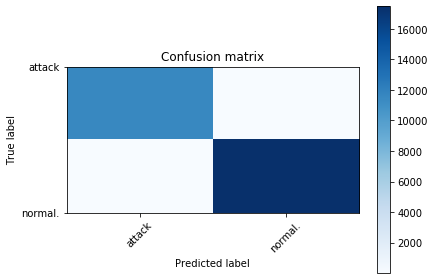

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     11623
           1       1.00      1.00      1.00     17495

    accuracy                           1.00     29118
   macro avg       1.00      1.00      1.00     29118
weighted avg       1.00      1.00      1.00     29118



In [46]:
cm_visual(y_true, relu_adam_pred, outcome)

### Relu Adam CNN

[[11583    40]
 [   25 17470]]


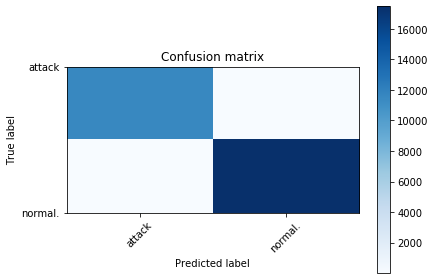

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11623
           1       1.00      1.00      1.00     17495

    accuracy                           1.00     29118
   macro avg       1.00      1.00      1.00     29118
weighted avg       1.00      1.00      1.00     29118



In [47]:
cm_visual(y_true, relu_adam_pred_cnn, outcome)

### Sigmoid SGD CNN

[[11564    59]
 [   96 17399]]


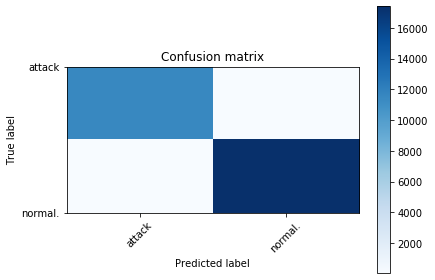

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11623
           1       1.00      0.99      1.00     17495

    accuracy                           0.99     29118
   macro avg       0.99      0.99      0.99     29118
weighted avg       0.99      0.99      0.99     29118



In [48]:
cm_visual(y_true, sigmoid_sgd_pred_cnn, outcome)

### Tanh Adam CNN

[[11596    27]
 [   26 17469]]


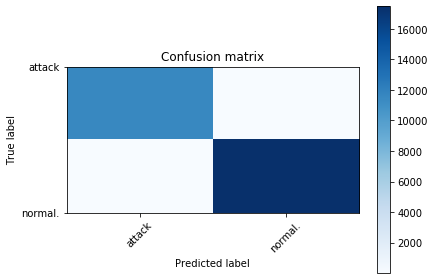

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11623
           1       1.00      1.00      1.00     17495

    accuracy                           1.00     29118
   macro avg       1.00      1.00      1.00     29118
weighted avg       1.00      1.00      1.00     29118



In [49]:
cm_visual(y_true, tanh_adam_pred_cnn, outcome)

## Best Model Predictions

In [50]:
f1_scores = {relu_adam_score: ['Relu Adam Fully Connected NN', relu_adam_pred], 
             relu_adam_score_cnn: ['Relu Adam CNN', relu_adam_pred_cnn], 
             sigmoid_sgd_score_cnn: ['Sigmoid SGD CNN', sigmoid_sgd_pred_cnn], 
             tanh_adam_score_cnn: ['Tanh Adam CNN', tanh_adam_pred_cnn]}
best_model_f1_score = max(f1_scores)
print('Best Model is ' +  f1_scores[best_model_f1_score][0] + ' with a F1_score of: ' + str(best_model_f1_score))

Best Model is Tanh Adam CNN with a F1_score of: 0.9981798068997695


In [51]:
best_model_pred = f1_scores[best_model_f1_score][1]
best_df = pd.concat([pd.DataFrame(outcome[best_model_pred]), pd.DataFrame(outcome[y_true])], axis=1)
best_df.columns = ['Predictions', "True Value"]
best_df

,Predictions,True Value
0,normal.,normal.
1,normal.,normal.
2,attack,attack
3,attack,attack
4,attack,attack
...,...,...
29113,normal.,normal.
29114,normal.,normal.
29115,attack,attack
29116,normal.,normal.


# Multi-Class Classification

### Count of each distinct value in outcome feature. Most of the outcomes are either normal or a neptune attack.

In [90]:
multi_data.groupby('outcome')['outcome'].count()

outcome
back.                 968
buffer_overflow.       30
ftp_write.              8
guess_passwd.          53
imap.                  12
ipsweep.              651
land.                  19
loadmodule.             9
multihop.               7
neptune.            51820
nmap.                 158
normal.             87832
perl.                   3
phf.                    4
pod.                  206
portsweep.            416
rootkit.               10
satan.                906
smurf.                641
spy.                    2
teardrop.             918
warezclient.          893
warezmaster.           20
Name: outcome, dtype: int64

### Label Encode target feature

In [91]:
print(multi_data.shape)
multi_outcome = encode_text_index(multi_data, 'outcome')
print(multi_outcome)
multi_data['outcome']

(145586, 124)
['back.' 'buffer_overflow.' 'ftp_write.' 'guess_passwd.' 'imap.'
 'ipsweep.' 'land.' 'loadmodule.' 'multihop.' 'neptune.' 'nmap.' 'normal.'
 'perl.' 'phf.' 'pod.' 'portsweep.' 'rootkit.' 'satan.' 'smurf.' 'spy.'
 'teardrop.' 'warezclient.' 'warezmaster.']


0         11
1         11
2         11
3         11
4         11
          ..
145581    11
145582    11
145583    11
145584    11
145585    11
Name: outcome, Length: 145586, dtype: int32

## Feature Importance Analysis using Logistic Regression

In [92]:
reg_data = multi_data.drop('outcome', axis=1)

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(reg_data, multi_data['outcome'], test_size=0.2, random_state=45)

# Training Set
print(x_train_reg.shape)
print(y_train_reg.shape)

# Test set
print(x_test_reg.shape)
print(y_test_reg.shape)

(116468, 123)
(116468,)
(29118, 123)
(29118,)


In [93]:
# Create logistic regression model
regressor = LogisticRegression(max_iter=1000)

# Fit/train logistic regression
regressor.fit(x_train_reg, y_train_reg)

# Predict
pred = regressor.predict(x_test_reg)

C:\Users\zey13\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,coef,positive
num_root,-5.722114,False
service-ftp,-5.454615,False
is_guest_login-1,-5.454611,False
dst_host_srv_diff_host_rate,-3.045237,False
dst_host_diff_srv_rate,-2.759617,False
...,...,...
flag-RSTR,2.000072,True
is_guest_login-0,5.457209,True
num_compromised,6.697679,True
service-http,7.783822,True


Intercept: [-17.48486506  -0.54288406  -2.83935974   0.82758094   2.15466757
  -2.93937877   2.40678317  -1.20698843   1.41910203   3.46722795
  -0.32337304  11.18431929  -1.03130661   1.8970486    1.55644163
  -1.18843342   1.35753224   4.51073317   3.1802893   -1.08100252
  -6.51430408   1.19016985]


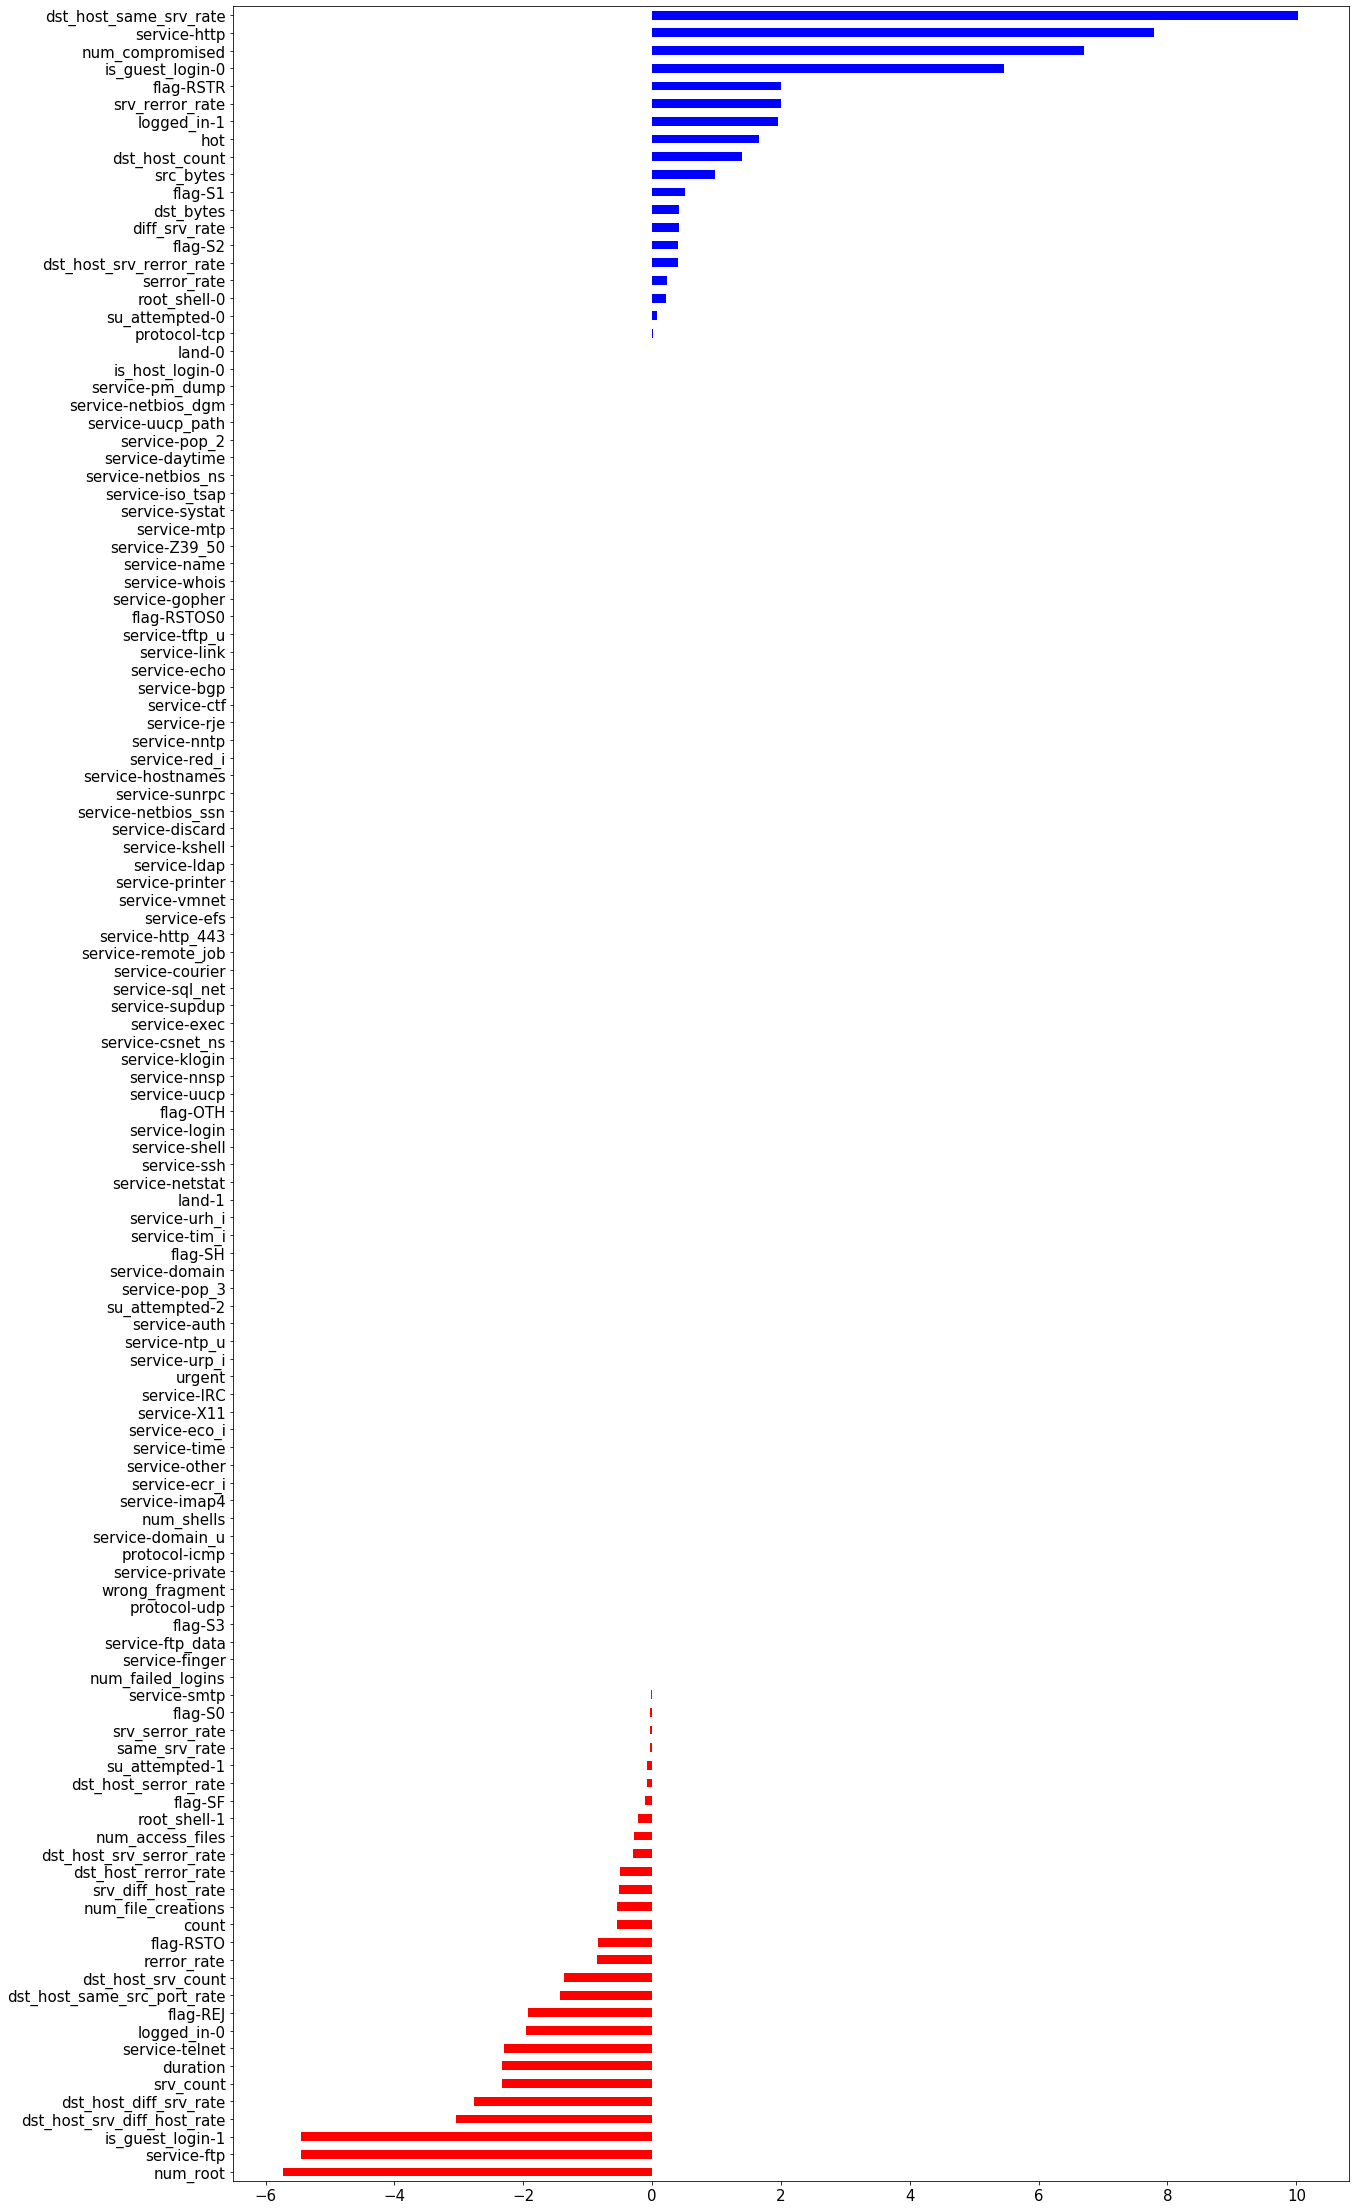

In [94]:
names = list(multi_data.columns.values)
names.remove("outcome")
names = np.array(names)

coefs = report_coef(names, regressor.coef_[0], regressor.intercept_)

In [95]:
index_names = coefs[ (coefs['coef'] < 1) & (coefs['coef'] > -1) ].index

print(len(index_names))
list(index_names)

102


['rerror_rate',
 'flag-RSTO',
 'count',
 'num_file_creations',
 'srv_diff_host_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_serror_rate',
 'num_access_files',
 'root_shell-1',
 'flag-SF',
 'dst_host_serror_rate',
 'su_attempted-1',
 'same_srv_rate',
 'srv_serror_rate',
 'flag-S0',
 'service-smtp',
 'num_failed_logins',
 'service-finger',
 'service-ftp_data',
 'flag-S3',
 'protocol-udp',
 'wrong_fragment',
 'service-private',
 'protocol-icmp',
 'service-domain_u',
 'num_shells',
 'service-imap4',
 'service-ecr_i',
 'service-other',
 'service-time',
 'service-eco_i',
 'service-X11',
 'service-IRC',
 'urgent',
 'service-urp_i',
 'service-ntp_u',
 'service-auth',
 'su_attempted-2',
 'service-pop_3',
 'service-domain',
 'flag-SH',
 'service-tim_i',
 'service-urh_i',
 'land-1',
 'service-netstat',
 'service-ssh',
 'service-shell',
 'service-login',
 'flag-OTH',
 'service-uucp',
 'service-nnsp',
 'service-klogin',
 'service-csnet_ns',
 'service-exec',
 'service-supdup',
 'service-sql_net',


In [96]:
multi_data = multi_data.drop(index_names, axis=1, inplace=False)
multi_data

,duration,hot,num_compromised,num_root,srv_count,srv_rerror_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,...,outcome,service-ftp,service-http,service-telnet,flag-REJ,flag-RSTR,logged_in-0,logged_in-1,is_guest_login-0,is_guest_login-1
0,-0.10785,-0.070209,-0.007905,-0.01039,-0.163048,-0.351068,-1.740377,-1.054220,0.979268,-0.417554,...,11,0,1,0,0,0,0,1,1,0
1,-0.10785,-0.070209,-0.007905,-0.01039,-0.163048,-0.351068,-1.639467,-0.967047,0.979268,-0.417554,...,11,0,1,0,0,0,0,1,1,0
2,-0.10785,-0.070209,-0.007905,-0.01039,-0.163048,-0.351068,-1.538557,-0.879875,0.979268,-0.417554,...,11,0,1,0,0,0,0,1,1,0
3,-0.10785,-0.070209,-0.007905,-0.01039,-0.228118,-0.351068,-1.437647,-0.792702,0.979268,-0.417554,...,11,0,1,0,0,0,0,1,1,0
4,-0.10785,-0.070209,-0.007905,-0.01039,-0.228118,-0.351068,-1.336736,-0.705529,0.979268,-0.417554,...,11,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145581,-0.10785,-0.070209,-0.007905,-0.01039,-0.260653,-0.351068,-0.963369,1.090228,0.979268,-0.417554,...,11,0,1,0,0,0,0,1,1,0
145582,-0.10785,-0.070209,-0.007905,-0.01039,-0.228118,-0.351068,-1.770650,1.090228,0.979268,-0.417554,...,11,0,1,0,0,0,0,1,1,0
145583,-0.10785,-0.070209,-0.007905,-0.01039,0.162302,-0.351068,-1.669740,1.090228,0.979268,-0.417554,...,11,0,1,0,0,0,0,1,1,0
145584,-0.10785,-0.070209,-0.007905,-0.01039,-0.032908,-0.351068,-1.568830,1.090228,0.979268,-0.417554,...,11,0,1,0,0,0,0,1,1,0


## Training and Test Split
#### Dividing data set into training and test sets. 80% of the records are part of the training set and 20% are for testing. The outcome column is our target (output).

In [97]:
x, y = to_xy(multi_data, 'outcome')
print(x.shape)
print(y.shape)

(145586, 21)
(145586, 23)


In [98]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=45)

# Training Set
print(x_train.shape)
print(y_train.shape)

# Test set
print(x_test.shape)
print(y_test.shape)

(116468, 21)
(116468, 23)
(29118, 21)
(29118, 23)


### Convolutional Neural network with 9 total layers. Two convolutional layers, one with 32 kernels and one with 64. 1 by 5 kernel size. Relu activation function. Adam optimizer. One Dense hidden layer with 1000 neurons. Dropout of 0.2

In [99]:
x_train_cnn = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], 1))
x_test_cnn = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], 1))
input_shape = (1, x_train.shape[1], 1)

print(x_train_cnn.shape)
print(x_test_cnn.shape)
print(input_shape)

(116468, 1, 21, 1)
(29118, 1, 21, 1)
(1, 21, 1)


In [100]:
# Save best model with best weights
checkpointer = ModelCheckpoint(filepath=os.path.join(save_path, "multi_cnn.hdf5"), 
                               verbose=0, save_best_only=True)

# Run model training three times to jump out of local optimum 
for i in range(3):
    print('\nRun: ', i + 1)
    
    multi_cnn = Sequential()
    
    multi_cnn.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
    multi_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    multi_cnn.add(Conv2D(64, (1, 5), activation='relu'))
    multi_cnn.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
    multi_cnn.add(Flatten())
    multi_cnn.add(Dense(1000, activation='relu'))
    multi_cnn.add(Dropout(0.2))
    multi_cnn.add(Dense(y_train.shape[1], activation='softmax'))

    # Use categorical crossentropy loss since it is a classification problem
    multi_cnn.compile(loss='categorical_crossentropy', optimizer='adam')

    # Stop training when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')

    multi_cnn.fit(x_train_cnn, y_train, validation_data=(x_test_cnn, y_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Train on 116468 samples, validate on 29118 samples
Epoch 1/1000
116468/116468 - 21s - loss: 0.0778 - val_loss: 0.0384
Epoch 2/1000
116468/116468 - 18s - loss: 0.0363 - val_loss: 0.0380
Epoch 3/1000
116468/116468 - 18s - loss: 0.0304 - val_loss: 0.0260
Epoch 4/1000
116468/116468 - 18s - loss: 0.0271 - val_loss: 0.0286
Epoch 5/1000
116468/116468 - 22s - loss: 0.0257 - val_loss: 0.0344
Epoch 6/1000
116468/116468 - 18s - loss: 0.0234 - val_loss: 0.0258
Epoch 00006: early stopping

Run:  2
Train on 116468 samples, validate on 29118 samples
Epoch 1/1000
116468/116468 - 19s - loss: 0.0784 - val_loss: 0.0370
Epoch 2/1000
116468/116468 - 19s - loss: 0.0357 - val_loss: 0.0312
Epoch 3/1000
116468/116468 - 19s - loss: 0.0305 - val_loss: 0.0438
Epoch 4/1000
116468/116468 - 18s - loss: 0.0270 - val_loss: 0.0265
Epoch 5/1000
116468/116468 - 20s - loss: 0.0246 - val_loss: 0.0251
Epoch 6/1000
116468/116468 - 22s - loss: 0.0235 - val_loss: 0.0255
Epoch 7/1000
116468/116468 - 18s - loss: 0.0216 

### Load saved model

In [101]:
saved_multi_cnn = load_model(os.path.join(save_path, "multi_cnn.hdf5"))

## Model Evaluations
### Accuracy, Precision, Recall and F1 scores

In [102]:
multi_pred = saved_multi_cnn.predict(x_test_cnn)
multi_pred = np.argmax(multi_pred, axis=1) # raw probabilities to choose class (highest probability)
y_true= np.argmax(y_test, axis=1) 

multi_acc = metrics.accuracy_score(y_true, multi_pred)
print("Multi CNN Accuracy score: {}".format(multi_acc))
multi_prec = metrics.precision_score(y_true, multi_pred, average= "weighted")
print("Multi CNN Precision score: {}".format(multi_prec))
multi_rec = metrics.recall_score(y_true, multi_pred, average= "weighted")
print("Multi CNN Recall score: {}".format(multi_rec))
multi_score = metrics.f1_score(y_true, multi_pred, average= "weighted")
print("Multi CNN F1 score: {}".format(multi_score))

Multi CNN Accuracy score: 0.9948142042722714
Multi CNN Precision score: 0.9943461920089401
Multi CNN Recall score: 0.9948142042722714
Multi CNN F1 score: 0.9944833654492743


C:\Users\zey13\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix, Plot, and Classification Report

In [103]:
cm = metrics.confusion_matrix(y_true, multi_pred)
print(cm)

[[  201     0     0     0     0     0     0     0     0     0     0     4
      0     0     0     0     0     0     0     0     0     0]
 [    0     5     0     0     0     0     0     0     0     0     0     2
      0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     9     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     2     0     0     0     1     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   124     0     0     0     0     0     2
      0     1     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     2     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0    

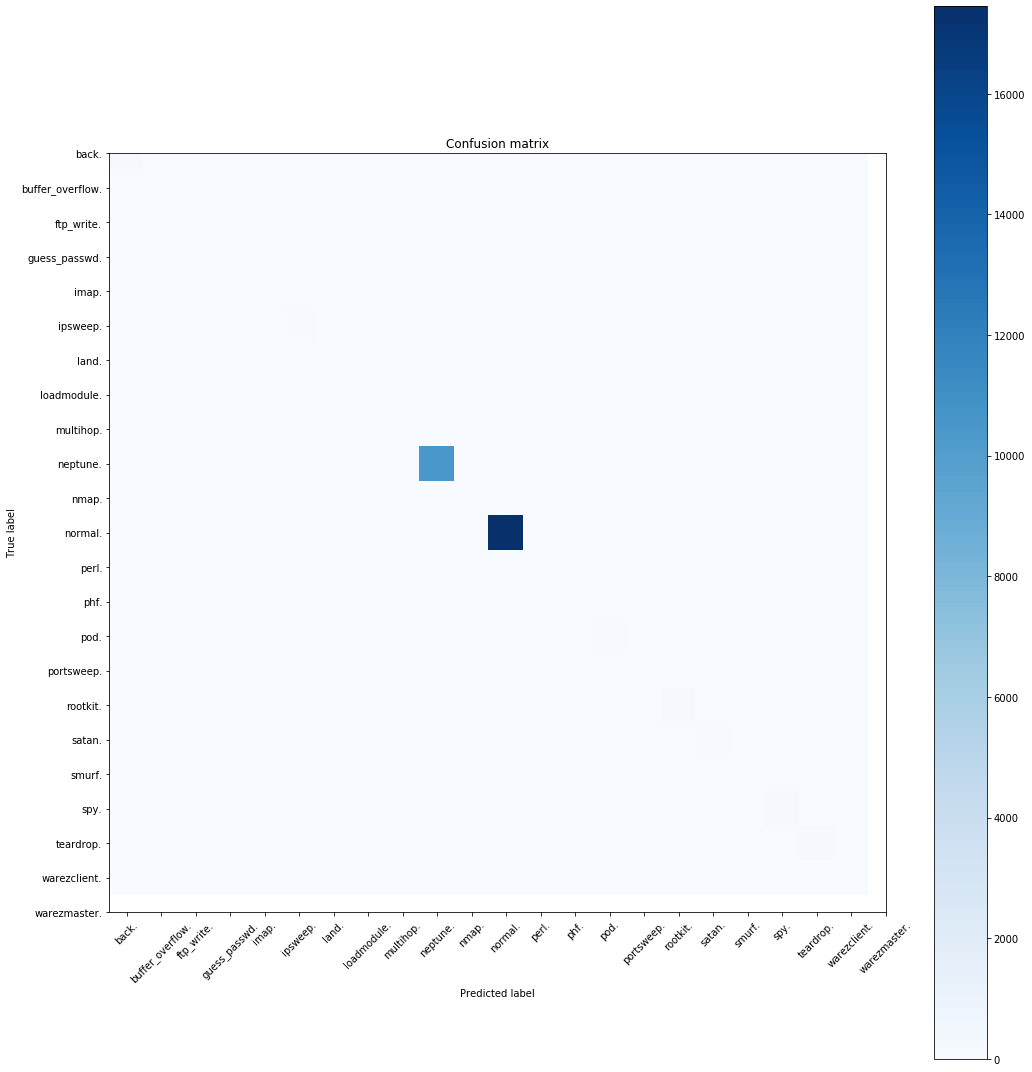

In [104]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plot_confusion_matrix(cm, multi_outcome)
plt.show()

In [105]:
print(metrics.classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       205
           1       0.62      0.71      0.67         7
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         9
           4       1.00      0.67      0.80         3
           5       0.98      0.96      0.97       127
           6       1.00      0.67      0.80         3
           7       1.00      0.50      0.67         2
           8       0.00      0.00      0.00         3
           9       1.00      1.00      1.00     10444
          10       0.91      0.94      0.93        33
          11       1.00      1.00      1.00     17495
          12       1.00      1.00      1.00         1
          14       1.00      1.00      1.00        35
          15       0.99      1.00      0.99        74
          16       0.00      0.00      0.00         2
          17       1.00      0.95      0.98       174
          18       0.99    

C:\Users\zey13\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Multi Class Model Predictions

In [106]:
multi_df = pd.concat([pd.DataFrame(multi_outcome[multi_pred]), pd.DataFrame(multi_outcome[y_true])], axis=1)
multi_df.columns = ['Predictions', "True Value"]
multi_df

,Predictions,True Value
0,normal.,normal.
1,normal.,normal.
2,neptune.,neptune.
3,neptune.,neptune.
4,neptune.,neptune.
...,...,...
29113,normal.,normal.
29114,normal.,normal.
29115,neptune.,neptune.
29116,normal.,normal.
